In [1]:
# Libraries and functions
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Own functions by preprocessing 
def pop_col(string, initial_age, final_age, df_):
    df = df_.copy()
    cols = [string+str(i) for i in range(initial_age, final_age+1)]
    df['Total'+string+str(initial_age)+'-'+str(final_age)] = 0
    for index in df.index:
        aux = 0
        for var in cols:
            aux  = aux + df.loc[index,var]
        df.loc[index,'Total'+string+str(initial_age)+'-'+str(final_age)] = aux
    return df[['Total'+string+str(initial_age)+'-'+str(final_age)]]


def complete(left, rigth, limit):
    left,rigth = str(left), str(rigth)
    domain = limit - (len(left) + len(rigth))
    for _ in range(domain):
        left = left + '0'
    code = left + rigth
    return code


# Own function for index inequalities 
def theil(df,year):
    data = df.copy()
    data.replace(0,0.00001, inplace=True)
    N = data.shape[0]
    data['share-var'] = data[year]/ data[year].sum()
    data['log-share-var'] = np.log(data['share-var']*N)
    theil = (data['share-var']*data['log-share-var']).sum()
    return theil/np.log(N)

def gini_col(df,year):
    data = df[[year]].copy()
    data.sort_values(year, inplace=True, ignore_index=True)
    N = data.shape[0]
    data['pop'] = [x for x in range(1,N+1)]
    Y = data[year].sum()
    data['share_income'] = data[year].cumsum() / Y
    data['share_pop'] = data['pop']/N
    zero = data.loc[[0]]
    data.loc[0] = 0
    data = pd.concat([zero,data]).reset_index(drop=True)
    #plt.plot(table['share_pop'], table['share_income'])
    #plt.plot([0,1], [0,1], color='k')
    areaB = 0
    for row in data.index[1:]:
        areaB = areaB +(data.loc[row-1,'share_income']+ data.loc[row,'share_income']) * ( data.loc[row,'share_pop'] -  data.loc[row-1,'share_pop'])
        gini = 1 - areaB
    return gini

In [2]:
# Population databases

dfpop = pd.read_excel("pop2017.xlsx", skiprows=11)
dfpop2018 =pd.read_excel("pop2018-2026.xlsx", skiprows=11)
dfpop.columns = dfpop.columns.str.replace("Total General","Total")
dfpop = pd.concat([dfpop, dfpop2018], ignore_index=True)
dfpop =dfpop[dfpop['ÁREA GEOGRÁFICA']=='Total'].reset_index(drop=True)  # Keep in database only 
dfpop['DPMP'] = dfpop['DPMP'].astype('str')  # Casting to string the key ( to merge )variable
dfpop.columns = dfpop.columns.str.replace('Total_100 y más', 'Total_100') # we change the name to apply quickly pop_col()
ages = [(0,0),(1,4), (5,14), (15,44), (45,64), (65,100)]
counter = 1
for age in ages:
    dfpop['range'+str(counter)] = pop_col('Total_', age[0], age[1], dfpop)
    counter +=1
dfpop =dfpop[['DP','DPNOM','DPMP','AÑO', 'range1', 'range2', 'range3', 'range4', 'range5',
       'range6']]
dfpop=pd.wide_to_long(dfpop, stubnames='range', i=['DP', 'DPNOM', 'DPMP', 'AÑO'], j='gru_ed2').reset_index()
dfpop.to_csv("population.csv")

dfpop = pd.read_csv("population.csv")


In [3]:
# Mortality databases to merge
"""
nofetales818 = ['Defun_'+str(x)+'.txt' for x in range(2008,2019)]
df = pd.DataFrame()
colsuv = set()
for nofetal in nofetales818:
    aux = pd.read_csv(nofetal, sep='\t', encoding='latin1',low_memory=False)
    aux.columns = map(str.upper, aux.columns)
    aux.columns = aux.columns.str.replace("CAUSA_666","CAUSA_667")
    for var in aux.columns:
        colsuv.add(var)
    df =  pd.concat((df,aux))
colsuv # what variables are well conactenated
#auxcols # Very useful to check the concatenation

nofetales = ['Defun_'+str(x)+'.csv' for x in range(2019,2021)]
df2 = pd.DataFrame()
auxcols = set(pd.read_csv(nofetales[0]  , encoding='latin1').columns) # register columns names that appear equal in all dataframes
for nofetal in nofetales:
    auxcols = auxcols & set(pd.read_csv(nofetal, encoding='latin1').columns)
    df2 = pd.concat((df2, pd.read_csv(nofetal, encoding='latin1')))
## Creating neccesary 
df = pd.concat((df,df2), ignore_index=True)

df['tbc'] = np.where(df['CAUSA_667']==102,1,0)
df['GRU_ED2'] = df['GRU_ED2'].astype('str') 
deaths_year = df.groupby(by=['ANO'])[['tbc']].sum()  # Check if there are not differences

df = df[-df['CODPTORE'].isna()]  # Drop people without information in CODPTORE
df['CODPTORE'] = df['CODPTORE'].astype('int64')

df = df[-df['CODMUNRE'].isna()]  # Drop people without information in codmunre
df['CODMUNRE'] = df['CODMUNRE'].astype('int64')

df['DPMP'] = 0
for index in df.index:
    if df.loc[index,'CODPTORE'] in [4,5,8]:
        df.loc[index,'DPMP'] = complete(df.loc[index,'CODPTORE'], df.loc[index,'CODMUNRE'], 4)
    else: 
        df.loc[index,'DPMP'] = complete(df.loc[index,'CODPTORE'], df.loc[index,'CODMUNRE'], 5)
df['DPMP'] = df['DPMP'].astype("int64")
df.to_csv("disease.csv")

df = pd.read_csv("disease.csv")
df = df[df['GRU_ED2']!=7] # Excluding whose 

set(df['DPMP'].unique()) - set(dfpop['DPMP'].unique())  # Review this
# To see which DPMP could be missing in both databases but all are well classified

group_var = ['ANO','DPMP','GRU_ED2']
df['Municipal deaths']= df.groupby(by=group_var)['tbc'].transform('sum')  # checking the behavior of count()
df = df[['ANO','DPMP', 'GRU_ED2', 'Municipal deaths']]
# The database only contain the useful variables to merge
df = df[-df.duplicated(subset=['ANO','DPMP','GRU_ED2'], keep='first')].reset_index(drop=True)
df['GRU_ED2'] = df['GRU_ED2'].astype('int64')
dfpop = dfpop[(dfpop['AÑO']<=2020) & (dfpop['AÑO']>=2008)]
full= df.merge(dfpop, left_on = ['ANO','DPMP','GRU_ED2' ], right_on = ['AÑO', 'DPMP','gru_ed2' ])
#full = full[full["_merge"]=="both"]
full.duplicated(subset=['ANO','DPMP', 'GRU_ED2']).sum()
full['TME'] = (full['Municipal deaths'] / full['range'])*100000
# Reference population

referencia_pop = dfpop.groupby(by=['AÑO','gru_ed2'])[['range']].sum().reset_index()

referencia_pop = referencia_pop[referencia_pop['AÑO']==2020]

referencia_pop['pi/p'] = referencia_pop['range'] / referencia_pop['range'].sum()

table = full.merge(referencia_pop, on='gru_ed2', indicator=True)
table.to_csv("table.csv")
"""

'\nnofetales818 = [\'Defun_\'+str(x)+\'.txt\' for x in range(2008,2019)]\ndf = pd.DataFrame()\ncolsuv = set()\nfor nofetal in nofetales818:\n    aux = pd.read_csv(nofetal, sep=\'\t\', encoding=\'latin1\',low_memory=False)\n    aux.columns = map(str.upper, aux.columns)\n    aux.columns = aux.columns.str.replace("CAUSA_666","CAUSA_667")\n    for var in aux.columns:\n        colsuv.add(var)\n    df =  pd.concat((df,aux))\ncolsuv # what variables are well conactenated\n#auxcols # Very useful to check the concatenation\n\nnofetales = [\'Defun_\'+str(x)+\'.csv\' for x in range(2019,2021)]\ndf2 = pd.DataFrame()\nauxcols = set(pd.read_csv(nofetales[0]  , encoding=\'latin1\').columns) # register columns names that appear equal in all dataframes\nfor nofetal in nofetales:\n    auxcols = auxcols & set(pd.read_csv(nofetal, encoding=\'latin1\').columns)\n    df2 = pd.concat((df2, pd.read_csv(nofetal, encoding=\'latin1\')))\n## Creating neccesary \ndf = pd.concat((df,df2), ignore_index=True)\n\ndf[\

In [4]:
table = pd.read_csv("table.csv")
table['TME*'] = table['TME']*table['pi/p']
# # Total mortality adjusted
table['Total TME*'] = table.groupby(by=['ANO','DPMP'])['TME*'].transform('sum')
table = table[-table.duplicated(subset=['ANO','DPMP'], keep='first')].reset_index(drop=True)
map_df = table.copy() # We are going to uses after to plot the map
table = table[['AÑO_x','DPMP','Total TME*']]
N_municipios = table.shape[0]
table = table.pivot(index='DPMP', columns='AÑO_x', values='Total TME*')  # This will be a structure to read, not to handled
table.dropna(inplace=True)
table.reset_index(drop=True, inplace=True)
table

FileNotFoundError: [Errno 2] No such file or directory: 'table.csv'

In [ ]:
table[2020].describe()

count    1105.000000
mean        1.235100
std         3.427104
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        54.286321
Name: 2020, dtype: float64

In [ ]:
notbc = [(table[año]==0).sum() for año  in range(2008,2021)]

In [ ]:
# Plotting
domain = [x for x in range(2008,2021)]
ginis = [gini_col(table,year) for year in domain]
theils = [theil(table,year) for year in domain]
table_statistics = pd.DataFrame({'periodo':domain, 'TMR zero':notbc, 'Gini':ginis, 'Theil':theils})
table_statistics = table_statistics.merge(deaths_year, left_on='periodo', right_on='ANO')
table_statistics.describe().round(2).to_excel('summary.xlsx')

In [ ]:
table_statistics

,periodo,TMR zero,Gini,Theil,tbc
0,2008,813,0.849218,0.236309,1171
1,2009,824,0.855320,0.240252,1096
2,2010,837,0.858063,0.242748,971
3,2011,848,0.878377,0.278380,902
4,2012,840,0.863580,0.249287,965
5,2013,830,0.869478,0.260412,1006
6,2014,826,0.859434,0.247689,1031
7,2015,820,0.852439,0.238098,1023
8,2016,812,0.860104,0.249668,1070
9,2017,822,0.864810,0.251038,1022


In [ ]:
print(1105-853)

252


In [ ]:
(252/1105)*100


22.805429864253394

In [ ]:
table_statistics[['tbc']].pct_change(periods=1)

,tbc
0,NaN
1,-0.064048
2,-0.114051
3,-0.071061
4,0.069845
5,0.042487
6,0.024851
7,-0.007759
8,0.045943
9,-0.044860


In [ ]:
table_statistics.describe()

,periodo,TMR zero,Gini,Theil,tbc
count,13.00000,13.000000,13.000000,13.000000,13.000000
mean,2014.00000,826.923077,0.859219,0.247380,1032.153846
std,3.89444,14.436421,0.010524,0.013301,72.356578
min,2008.00000,803.000000,0.836571,0.224226,902.000000
25%,2011.00000,820.000000,0.853413,0.240252,971.000000
50%,2014.00000,824.000000,0.859434,0.247689,1023.000000
75%,2017.00000,837.000000,0.864810,0.251038,1082.000000
max,2020.00000,853.000000,0.878377,0.278380,1171.000000


In [ ]:
table_statistics[['tbc']].pct_change(periods=1)['tbc'].sum()

-0.15956113431059005

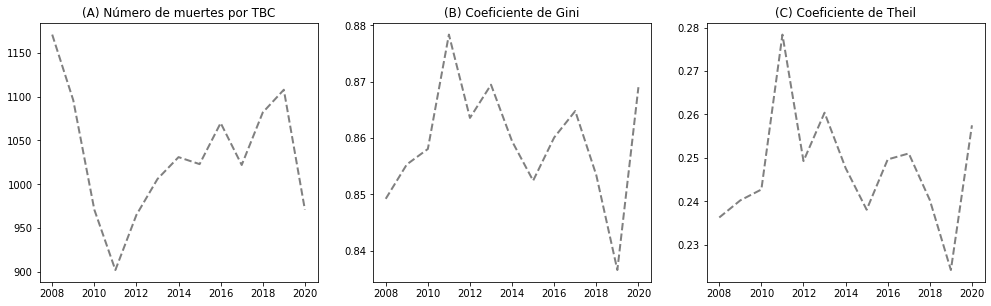

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(15,3))  # Two rows, one column.
plt.subplots_adjust(bottom=0.001, right=1, top=1.2)
axis[0].plot(table_statistics['periodo'], table_statistics['tbc'], linewidth=2, color='gray',  linestyle='--')
axis[0].set_title("(A) Número de muertes por TBC")
axis[0].plot()
axis[1].plot(domain, ginis, linewidth=2, color='gray',  linestyle='--')
axis[1].plot()
axis[1].set_title("(B) Coeficiente de Gini")
axis[2].plot(domain, theils, linewidth=2, color='gray',  linestyle='--')
axis[2].set_title("(C) Coeficiente de Theil")
axis[2].plot()
plt.savefig('inequality-measure.jpg', bbox_inches='tight')

In [ ]:
# Running gini and theil in R

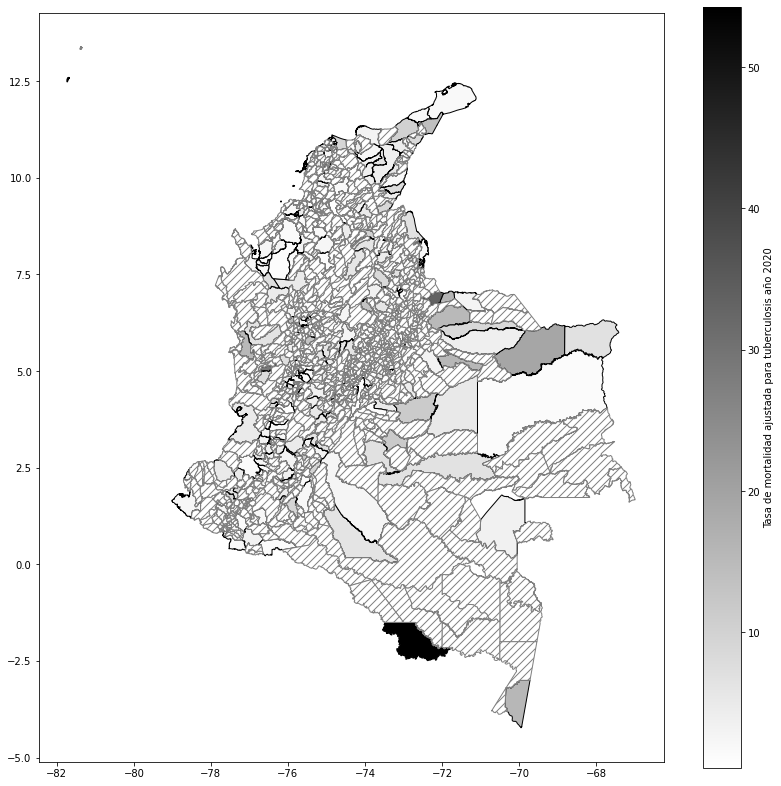

In [ ]:
import geopandas as gpd
geomap  = gpd.read_file("MGN_MPIO_POLITICO.shp")
geomap['MPIO_CDPMP'] = geomap['MPIO_CDPMP'].astype('int64')
map_df = map_df[map_df['AÑO_x']==2020].reset_index(drop=True)
map_df = map_df[['DPMP','DPNOM', 'AÑO_x', 'Total TME*','Municipal deaths']]
map_plot = geomap.merge(map_df, left_on=['MPIO_CDPMP'], right_on=['DPMP'])
map_plot.replace(0,np.nan, inplace=True)
map_plot.plot(
column="Total TME*",
cmap='binary',
edgecolor='black',
alpha=1,
legend=True,
figsize=(14, 14),
missing_kwds={
        "color": "white",
        "edgecolor": "gray",
        "hatch": "///",
        "label": "Missing values",    },
legend_kwds={
     'label': "Tasa de mortalidad ajustada para tuberculosis año 2020",
    'orientation': "vertical"
 })
plt.savefig("Mapa.png")

In [ ]:
map_plot[-map_plot['Total TME*'].isna()]['DPTO_CNMBR'].value_counts()

ANTIOQUIA                                                   27
CUNDINAMARCA                                                18
VALLE DEL CAUCA                                             16
CAUCA                                                       15
TOLIMA                                                      12
SANTANDER                                                   12
BOYACÁ                                                      11
CESAR                                                       11
CÓRDOBA                                                     11
HUILA                                                       11
ATLÁNTICO                                                   11
BOLÍVAR                                                     10
MAGDALENA                                                    9
NORTE DE SANTANDER                                           9
NARIÑO                                                       8
META                                                   